# Susceptible-Infected-Quarantined-Recovered model

### Model

The model we choose is a Susceptible-Infected-Quarantined-Recovered (SIQR) with birth and death rates.  
In this case, we choose Quarantined to be the fraction of the population being discovered to carry coronavirus, thus quarantied and with no possibility to infect other people. Only Infected (but not discovered) people can spread the illness.
Quarantined people is the variable to be fit to real confirmed cases data.

In [1]:
from scipy.integrate import odeint, solve_ivp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.optimize import minimize
from scipy.optimize import Bounds
import os
from datetime import date
import requests

For this compartmental model, we choose to fit the parameters on the data on confirmed cases provided by the World Health Organization (WHO), collected by this site: https://ourworldindata.org/coronavirus-source-data 

In [2]:
today = date.today()
filename_cases = today.strftime("%Y_%m_%d")+'.csv'
filename_deaths = today.strftime("%Y_%m_%d")+'deaths.csv'

In [3]:
url='https://covid.ourworldindata.org/data/ecdc/total_cases.csv'
response = requests.get(url)
with open(os.path.join("data", filename_cases), 'wb') as f:
    f.write(response.content)
url='https://covid.ourworldindata.org/data/ecdc/total_deaths.csv'
response = requests.get(url)
with open(os.path.join("data", filename_deaths), 'wb') as f:
    f.write(response.content)

In [27]:
df=pd.read_csv('data/'+filename_cases)
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

dfD=pd.read_csv('data/'+filename_deaths)
dfD['date']=pd.to_datetime(dfD['date'])
dfD.set_index('date',inplace=True)

country='Italy'
population=60480000.

# Start of the study in order to fit on the last 20 days
#(can be modified as wanted)
#start = today-pd.DateOffset(days=21)
start=pd.to_datetime('2020-03-01')
end = df.index.max()
print('Data updated to: ',str(end))
days=(end-start).days+1
t = np.linspace(start.value, end.value, days)
t = pd.to_datetime(t)

tempo=np.linspace(1,days,days)


Data updated to:  2020-03-22 00:00:00


Some explorations of the timeserie of the confirmed cases.

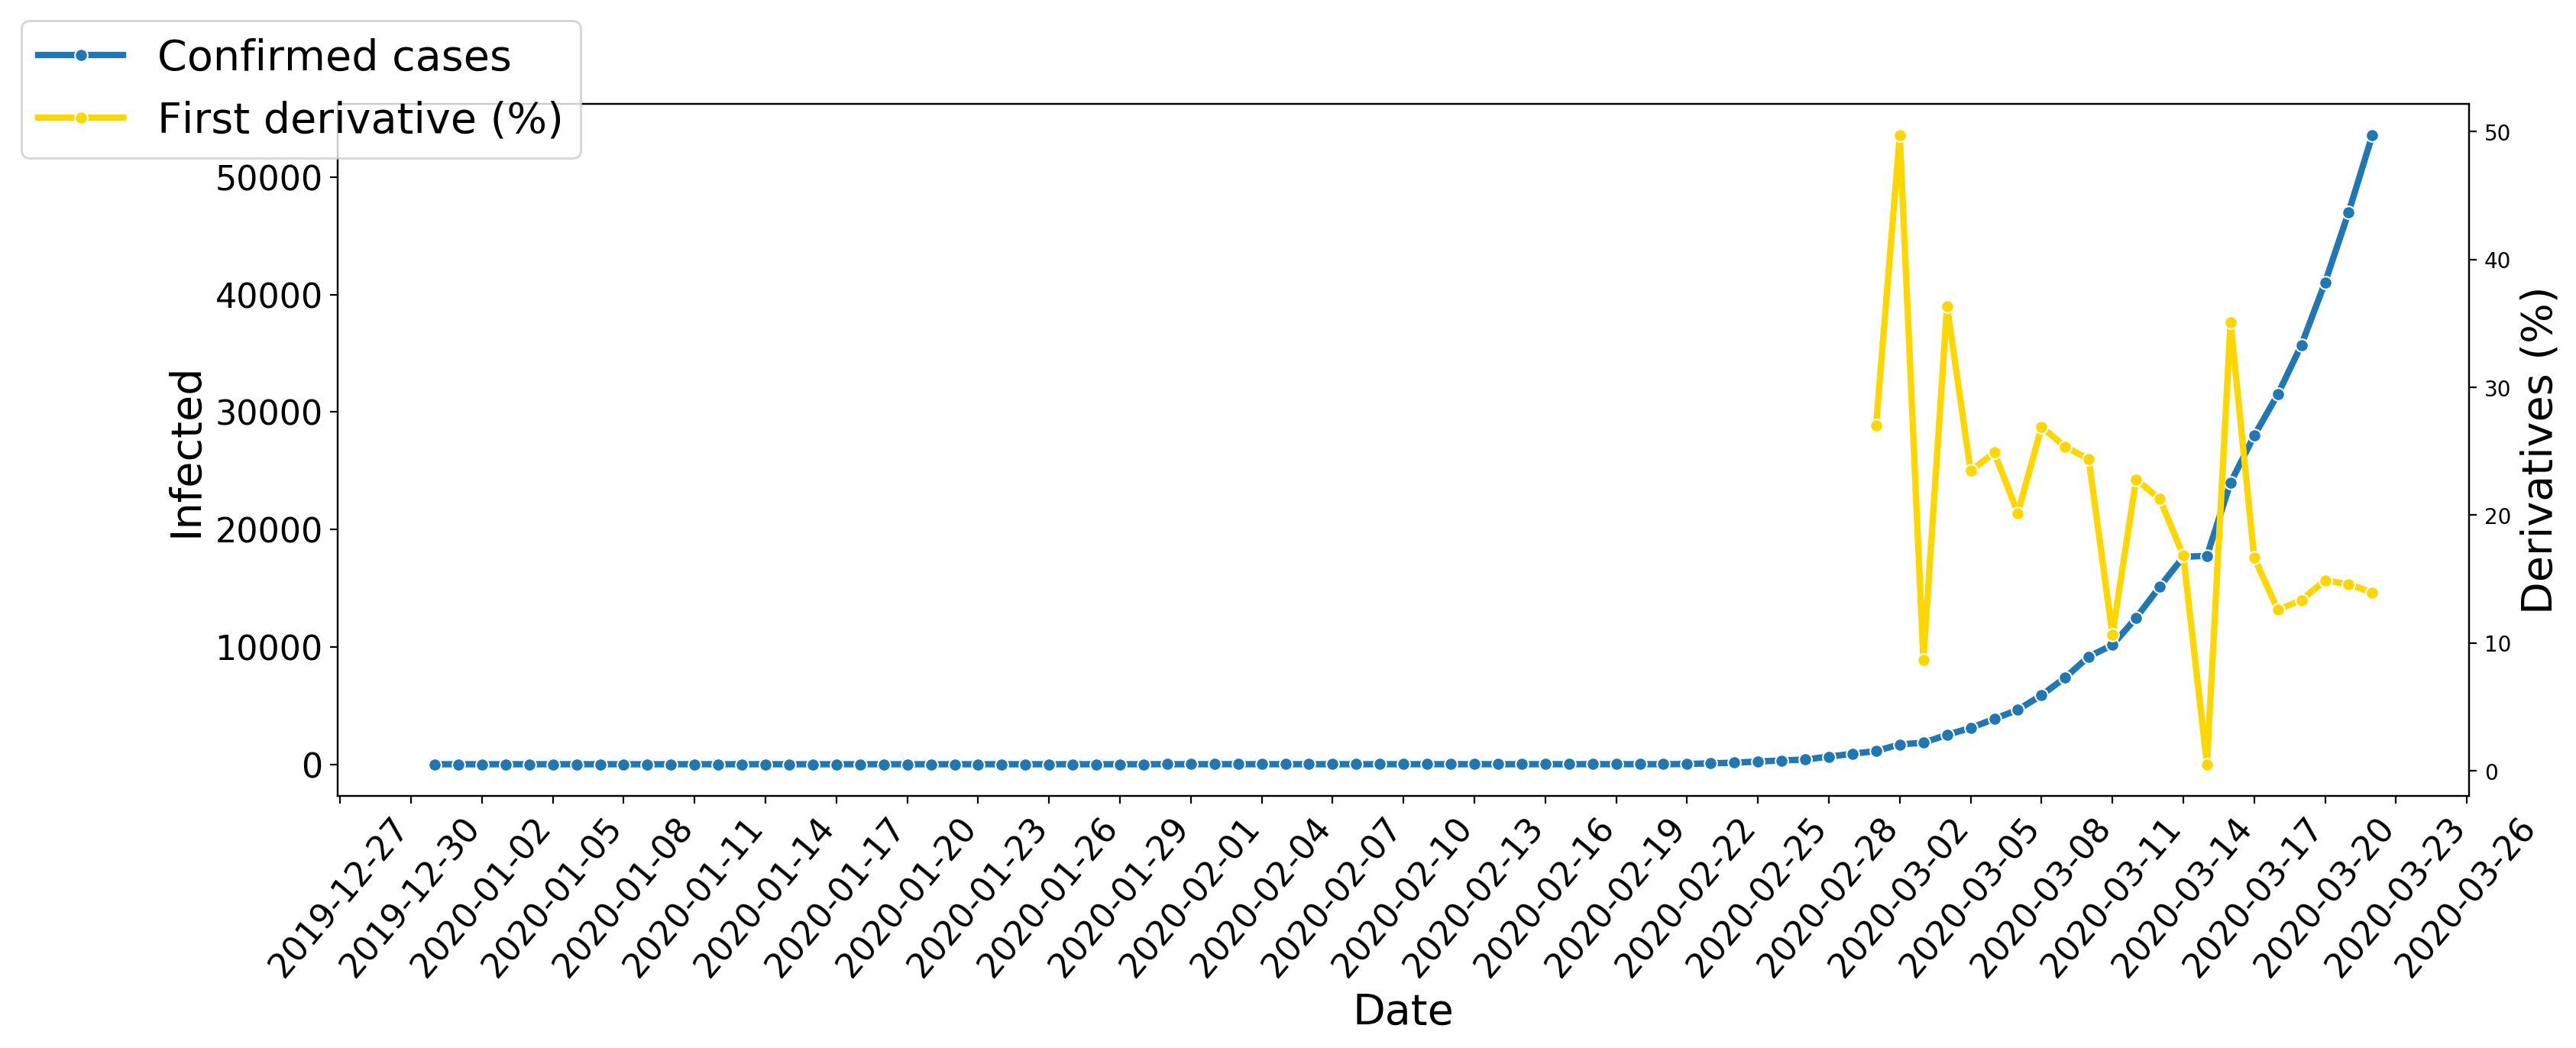

In [28]:
diff1=df[country].pct_change()*100 #first derivative
diff2=df[country].diff().pct_change()*100 #second derivative
diff1=diff1.loc[start:,]
diff2=diff2.loc[start:,]

f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,marker='o',
             label='Confirmed cases',ax=ax)
plt.setp(ax.lines,linewidth=3)


ax2 = ax.twinx()
sns.lineplot(x=diff1.index,y=diff1,ax=ax2,label='First derivative (%)',
             color='gold',marker='o')

#sns.lineplot(x=diff2.index,y=diff2,ax=ax2,label='Second derivative (%)',color='orange')
plt.setp(ax2.lines,linewidth=3)
ax2.set_ylabel('Derivatives (%)',fontsize=20)

#ax.lines[1].set_linestyle("--")

ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Infected',fontsize=20)

#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=16 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=16 )
#plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title
ax.get_legend().remove()
ax2.get_legend().remove()
ax2.figure.legend(loc='upper left',fontsize=20)


We specify that R0 is not directly a parameter of the model's equations, but you can derive it from other model parameters. Since R0 has the easy-to-say meaning of "secundary cases from a single infected person", it is very popular during this outbreak, and it is very useful to describe the behaviour of the epidemiological curves. (https://www.icts.res.in/sites/default/files/PuneR0talk.pdf)

In the next chunk, we initialize the parameter we know from literature about COVID-19 (reference will be provided). We also set up some values as a starting point for the fit of the parameters we do not know the value of.

In [29]:
#Known parameters:
#Number of days before being quarantined if symptomatic
days_inf=7
mu=1/days_inf

#Number of days to recover
days_ill=10
gamma=1/days_ill

#Percent of symptomatic carriers (prob of being quarantined instantaneously)
ps=0.3

#Birth rate
b=8.5*(population/1000)/365

#Prob od dying today
life_exp=82.54*365
d=1/life_exp

#Number of initial deaths of symptomatic carriers
Di0=dfD[dfD.index==start][country].iloc[0]

#Number of initial quarantined
Q0=df[df.index==start][country].iloc[0]

#Initial guess for I0
I0=Q0*(1-ps)/ps

The number of confirmed case is known, but it is almost certain that the number of real infected people is much higher than the number of confirmed cases. For this reason, we decide to retrieve the value of infected people at the beginning of the study ($I_0$) from the data, using the number of confirmed cases on the first day only as initial guessing.

Death rate (probability of dying today if having coronavirus) is estimated via Bayes rule:  
$P(A/B)=P(B/A)*P(A)/P(B)$
with A=_to die today_ and B=_having coronavirus_.
Fraction of total and dead people having coronavirus is that of today, but it changes over time.

In [30]:
PBA=dfD['Italy'].max()/(d*len(dfD[dfD['Italy']>0])*population)
print('Fraction of dead people carrying coronavirus: ',PBA)

PA=d
print('prob of dying today: ',PA)

PB=(df[df.index==df.index.max()][country].iloc[0]/population)
print('Fraction of people carrying coronavirus: ',PB)

d_i=PBA*PA/PB
print('prob of dying today if having coronavirus: ',d_i)

Fraction of dead people carrying coronavirus:  0.08291342347427477
prob of dying today:  3.319270689844027e-05
Fraction of people carrying coronavirus:  0.0008858796296296296
prob of dying today if having coronavirus:  0.0031066533999415617


In [31]:
R0=2.5
beta=(mu+d_i)*R0

$\beta$ has the meaning of the daily number of contacts for a susceptible individual, rescaled for the probability that a contact would be contagious in case the other one is an infected individual. 

In [32]:
print('Initial parameters: I0={}\nbeta={} mu={} b={} \nd={} d_i={}'.format(I0, 
                                                               beta,mu,b,d,
                                                                           d_i))
print('Q0= {}   gamma={}'.format(Q0,gamma))
N=population
x0=[N-I0-Q0,I0,Q0,0.,0.,Di0]
print(x0)
bounds = Bounds([0.0, 0.5*I0], [50., 5*I0])

Initial parameters: I0=2632.0
beta=0.36490949064271105 mu=0.14285714285714285 b=1408.4383561643835 
d=3.319270689844027e-05 d_i=0.0031066533999415617
Q0= 1128   gamma=0.1
[60476240.0, 2632.0, 1128, 0.0, 0.0, 29]


We have set initial conditions (that will be fitted to). We also defined some constraints for the interval of $\beta=[0.0,1.0]$ and $I_0=[I_0,10*I_0]$.

In [33]:
def sumsq(p):
    beta,I0=p
    x0=[population-I0-Q0,I0,Q0,0.,0.,Di0]
    def SIR_ode(t,x):
        S,I,Q,R,Dsir,Dq=x
        N=S+I+Q+R
        dS=b-beta*S*I/N-d*S
        dI=beta*S*I/N-mu*ps*I-d*I-gamma*I
        dQ=mu*ps*I-d_i*Q-gamma*Q
        dR=gamma*I+gamma*Q-d*R
        dDsir=d*S+d*I+d*R
        dDq=d_i*Q
        return [dS,dI,dQ,dR,dDsir,dDq]
    sol=solve_ivp(SIR_ode,[0,days],x0,t_eval=np.arange(0,days+1,1))
    return(sum((sol.y[2][:df.loc[start:,country].shape[0]][::1]-
                df.loc[start:,country])**2))

msol = minimize(sumsq,[beta,I0],method='L-BFGS-B',
                options={'maxiter':10000},bounds=bounds)


beta,I0=msol.x
R0=beta/(mu+d_i)
print('\nFitted parameters:\nI0= ',I0)
print('beta:',beta)
print('R0:',R0)


Fitted parameters:
I0=  13160.0
beta: 0.2976725484278459
R0: 2.039358772935438


In [34]:
def SIR(x,tempo):
    S,I,Q,R,Dsir,Dq=x
    N=S+I+Q+R
    dS=b-beta*S*I/N-d*S
    dI=beta*S*I/N-mu*ps*I-d*I-gamma*I
    dQ=mu*ps*I-d_i*Q-gamma*Q
    dR=gamma*I+gamma*Q-d*R
    dDsir=d*S+d*I+d*R
    dDq=d_i*Q
    return dS,dI,dQ,dR,dDsir,dDq

x0=[population-I0-Q0,I0,Q0,0.,0.,Di0]
integ = odeint(SIR, x0, tempo)
res=pd.DataFrame(integ,columns=['Susceptible','Infected','Quarantined','Recovered',
                                'DeadSane','DeadInfect'])
res['Step']=tempo
res['Day']=t

[None, None]

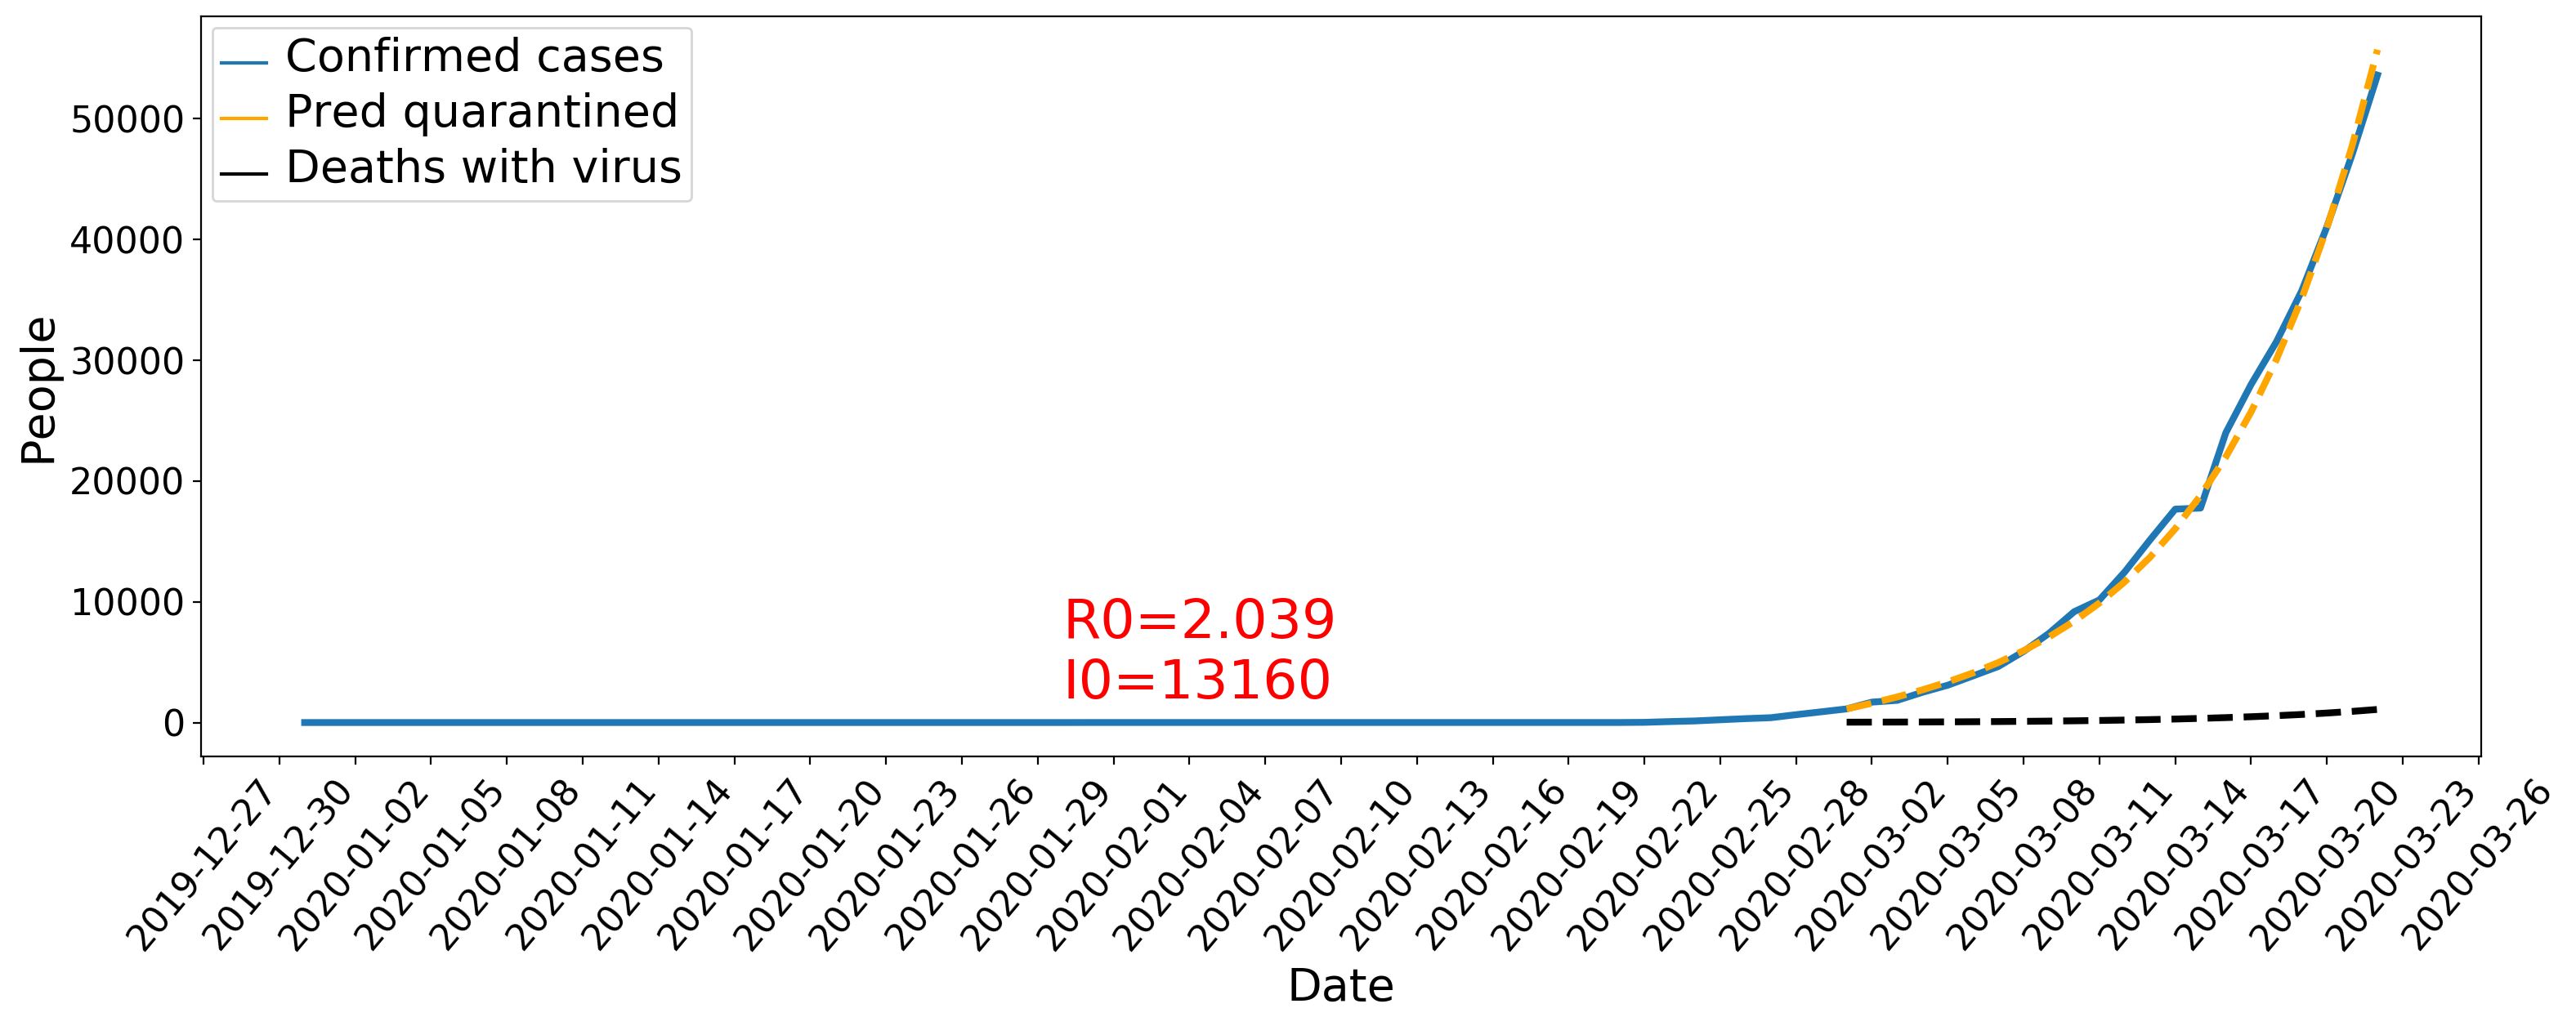

In [35]:
f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,markers='o',ax=ax,
             label='Confirmed cases')
sns.lineplot(x='Day',y='Quarantined',data=res,ax=ax,label='Pred quarantined',color='orange')
#sns.lineplot(x='Day',y='Infected',data=res,ax=ax,label='Pred infected',color='r')
#sns.lineplot(x='Day',y='DeadSane',data=res,ax=ax,label='Deaths without virus',color='grey')
sns.lineplot(x='Day',y='DeadInfect',data=res,ax=ax,label='Deaths with virus',color='black')
plt.setp(ax.lines,linewidth=3)
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('People',fontsize=20)
plt.annotate('R0={:1.3f}\nI0={}'.format(R0,int(I0)),
             xy=(mdates.date2num(df.index[30]), df[country][50]+2000),
             fontsize=24,color='r')
#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=16 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=16 )
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

### Long time behaviour

[None, None]

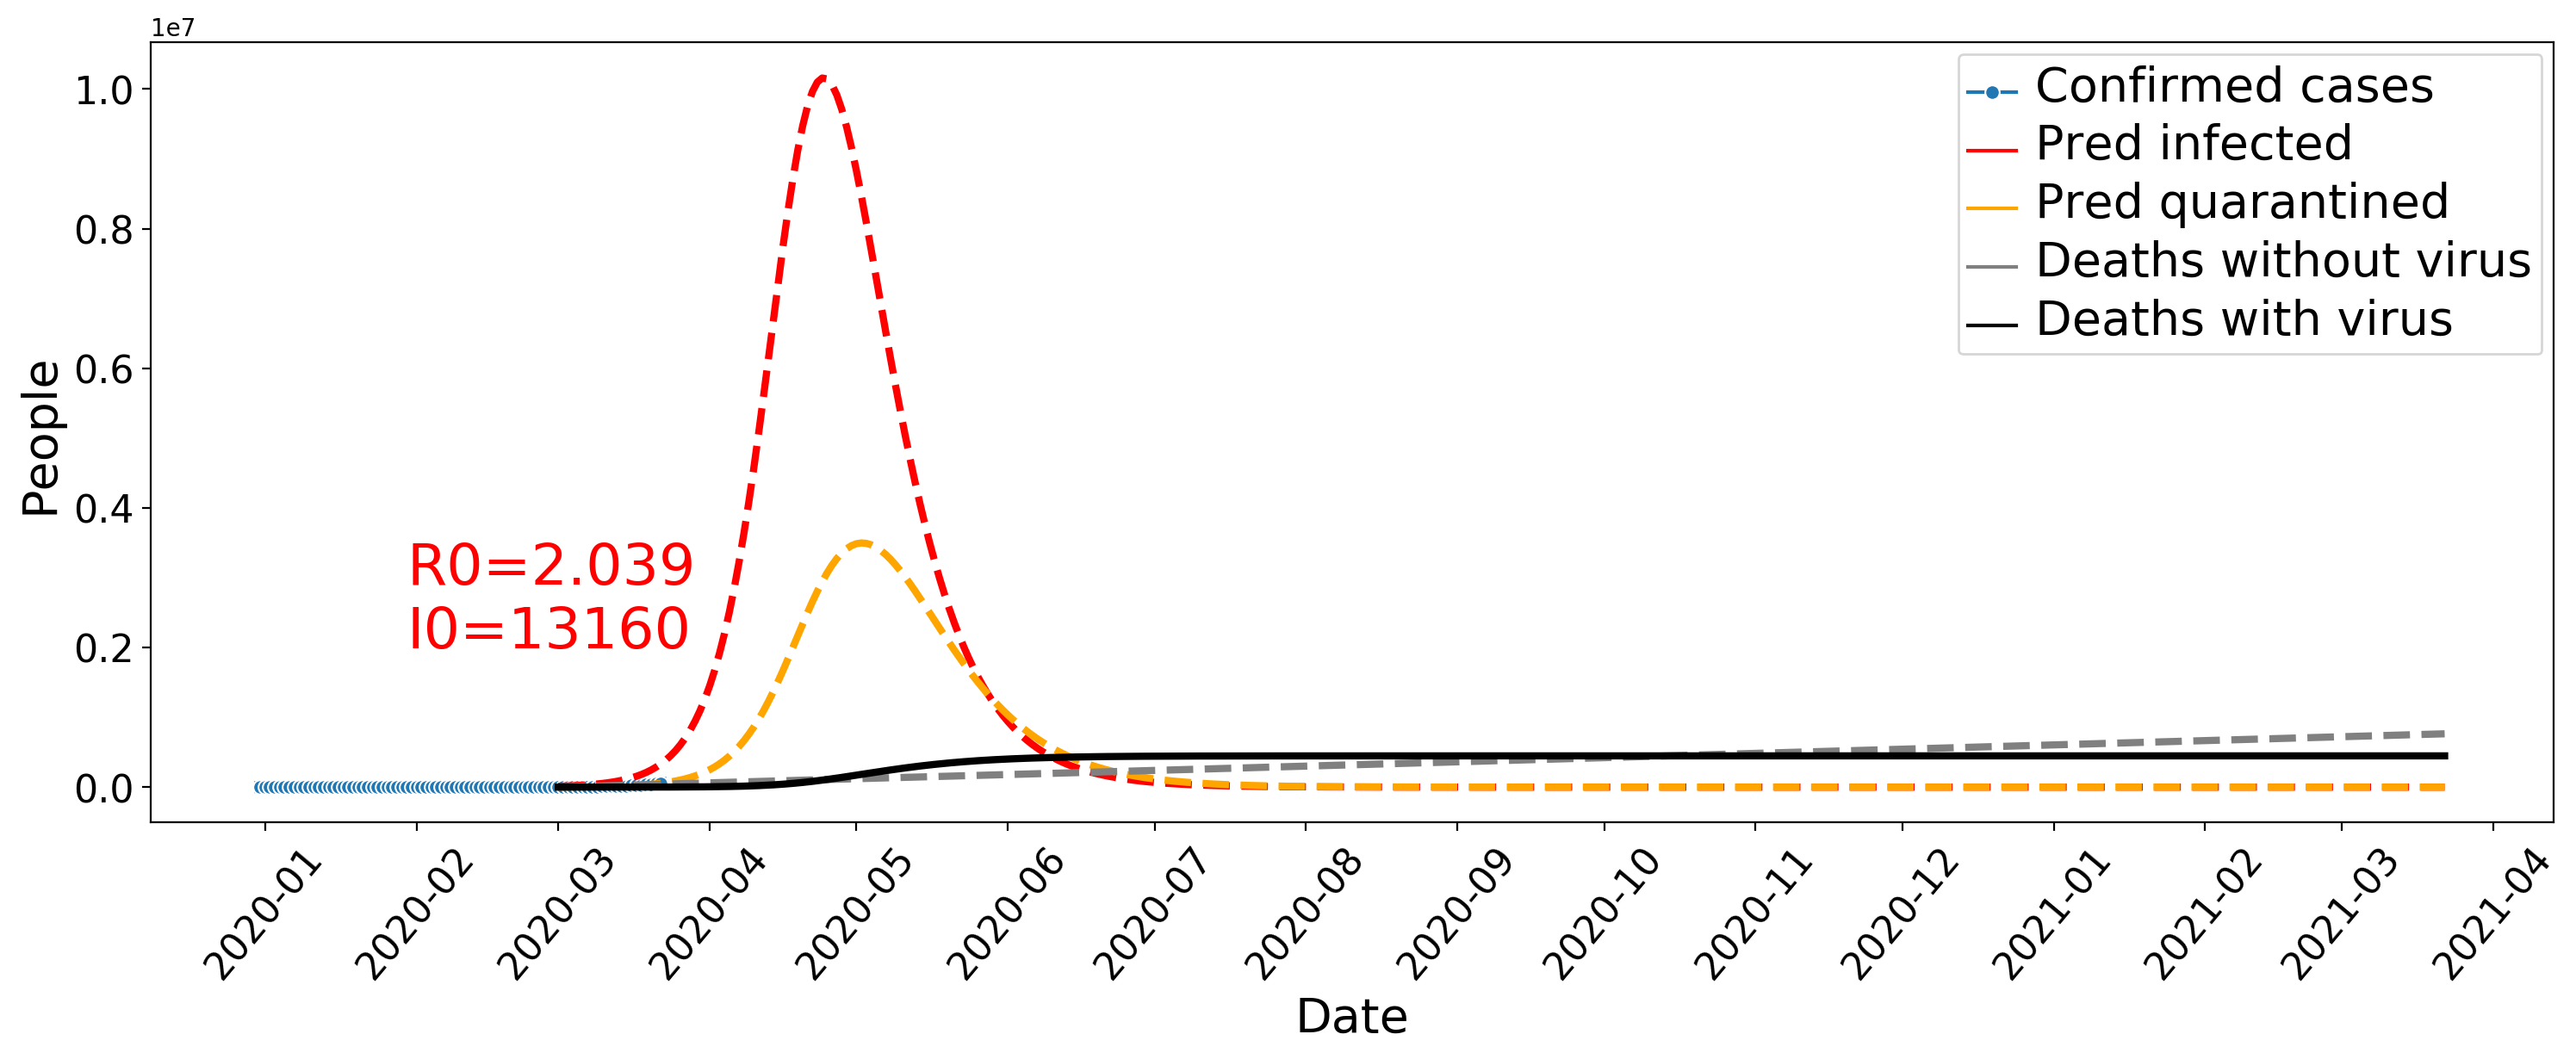

In [36]:
end = today+pd.DateOffset(years=1)
days=(end-start).days+1
t_long = np.linspace(start.value, end.value, days)
t_long = pd.to_datetime(t_long)
tempo_long=np.linspace(1,days,days)


integ = odeint(SIR, x0, tempo_long)
res_long=pd.DataFrame(integ,columns=['Susceptible','Infected','Quarantined','Recovered',
                                'DeadSane','DeadInfect'])
res_long['Step']=tempo_long
res_long['Day']=t_long

f,ax=plt.subplots(1,1,figsize=(18,6),dpi=200)
sns.lineplot(x=df.index,y=country,data=df,marker='o',ax=ax,
             label='Confirmed cases')
sns.lineplot(x='Day',y='Infected',data=res_long,ax=ax,label='Pred infected',color='r')
sns.lineplot(x='Day',y='Quarantined',data=res_long,ax=ax,label='Pred quarantined',color='orange')
sns.lineplot(x='Day',y='DeadSane',data=res_long,ax=ax,label='Deaths without virus',color='grey')
sns.lineplot(x='Day',y='DeadInfect',data=res_long,ax=ax,label='Deaths with virus',color='black')
plt.setp(ax.lines,linewidth=3)
ax.lines[0].set_linewidth(5)
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
#ax.lines[2].set_linestyle("--")
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('People',fontsize=20)
plt.annotate('R0={:1.3f}\nI0={}'.format(R0,int(I0)),
             xy=(mdates.date2num(df.index[30]), df[country][50]+2000000),
             fontsize=24,color='r')
#plt.yscale('log')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=16 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=16 )
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

In [37]:
#Number of total infected
TI=int(res_long['Infected'].iloc[-1]+res_long['Recovered'].iloc[-1]+
       res_long['DeadInfect'].iloc[-1])
print('Total infected from {} to {}: {}\n equal to {:2.2f} % of the population of {}'.format(
        start,end,TI,100*TI/population,country))

Total infected from 2020-03-01 00:00:00 to 2021-03-22 00:00:00: 49022951
 equal to 81.06 % of the population of Italy


In [38]:
#Number of deaths 
TDi=int(res_long['DeadInfect'].iloc[-1])
TD=TDi+int(res_long['DeadSane'].iloc[-1])
print('{} deaths with coronavirus from {} to {}:\n equal to {:2.2f} % of total deaths({})'.format(
        TDi,start,end,100*TDi/TD,TD))

447939 deaths with coronavirus from 2020-03-01 00:00:00 to 2021-03-22 00:00:00:
 equal to 36.96 % of total deaths(1211917)


## What if...

### beta=0, no coronavirus at all

In [39]:
end = today+pd.DateOffset(years=1)
days=(end-start).days+1
t_long = np.linspace(start.value, end.value, days)
t_long = pd.to_datetime(t_long)
tempo_long=np.linspace(1,days,days)

mu=1/days_inf
beta=0
integ = odeint(SIR, x0, tempo_long)
res_long=pd.DataFrame(integ,columns=['Susceptible','Infected','Quarantined',
                                     'Recovered',
                                'DeadSane','DeadInfect'])
res_long['Step']=tempo_long
res_long['Day']=t_long

In [40]:
#Number of deaths 
TDi=int(res_long['DeadInfect'].iloc[-1])
TD=TDi+int(res_long['DeadSane'].iloc[-1])
print('{} deaths from {} to {}'.format(
        TD,start,end))

773595 deaths from 2020-03-01 00:00:00 to 2021-03-22 00:00:00
